In [1]:
import time
import os, zipfile, requests, pandas as pd
import geopandas as gpd
import osmnx as ox, networkx as nx
import ast
import statistics
import numpy as np
#from sklearn.neighbors import BallTree
from shapely.geometry import Point
import random
from matplotlib import pyplot as plt
import matplotlib.path as mpltPath
import matplotlib.cm as cm
import matplotlib.colors as colors
import json 
from ast import literal_eval
import itertools
from collections import Counter
import descartes
import matplotlib



print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.10
nx 2.3


# Read routes file generated from microsim

In [165]:
paths = pd.read_csv("routes.csv", delimiter=':')

In [166]:
paths.head()

,p,route
0,0,"[255054,455748,255055,255060,255063,248808,244..."
1,1,"[542642,250334,256799]"
2,2,[]
3,3,[]
4,4,"[259587,576661,502686,258933,256164,258939,258..."


In [167]:
paths['route'] = paths['route'].apply(literal_eval)
paths['route'] = paths['route'].apply(lambda x: np.array(x))

In [168]:
type(paths['route'][0])

numpy.ndarray

# Get the count of each edge across all routes

In [169]:
some_list = paths['route']
totals = Counter(i for i in list(itertools.chain.from_iterable(some_list)))

In [170]:
edge_totals = pd.DataFrame.from_dict(totals, orient='index')

In [171]:
edge_totals = edge_totals.rename(columns={'index':'edge', 0:'count'})

In [172]:
edge_totals = edge_totals.sort_values(by=['count'], ascending=False)

In [173]:
edge_totals.head()

,count
253407,6810
510500,6689
425648,6685
563119,6622
564789,6622


# Histogram of edge count

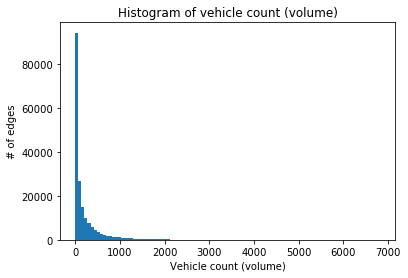

In [174]:
edge_totals.hist(column='count', bins=100)
plt.xlabel('Vehicle count (volume)')
plt.ylabel('# of edges')
plt.title('Histogram of vehicle count (volume)')
plt.grid(False)

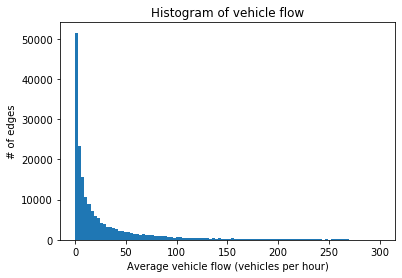

In [175]:
edge_totals['flow'] = edge_totals['count'] / 7
edge_totals.hist(column='flow', range=[0,300], bins=100)
plt.xlabel('Average vehicle flow (vehicles per hour)')
plt.ylabel('# of edges')
plt.title('Histogram of vehicle flow')
plt.grid(False)

# Get the average speeds of each person

In [176]:
#person_data = pd.read_csv("newest_point_5/test_point_5_sec_people_time_range_7_hr_run_20.csv")
#person_data = pd.read_csv("new_point_5/0_people_1.csv")
#person_data = pd.read_csv("0_people_new_test.csv")
#person_data = pd.read_csv("0_people.csv")
person_data = pd.read_csv("people.csv")

In [177]:
person_data.shape[0]

792910

In [178]:
person_data.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T
0,0,65306804,260193613,30560.8,12639,7401.59,8423.35,2224.840,1.00047,1.79952,1.801530
1,1,65295278,65373362,29371.8,13828,8102.08,9208.98,253.819,1.22198,1.55240,1.082570
2,2,65372268,890045132,33505.3,0,0.00,0.00,0.000,1.44350,1.30578,1.564190
3,3,719116877,65317030,36936.0,0,0.00,0.00,0.000,1.66599,1.05866,0.845222
4,4,65300085,1723739266,26938.1,16262,9527.01,10835.10,2352.780,1.88750,1.81203,1.326260


# Remove trips that did not have paths / no distances

In [179]:
person_data = person_data[person_data.num_steps != 0]
#person_data = person_data[person_data.distance != 0]
#person_data = person_data.dropna()

In [180]:
person_data.shape[0]

679205

In [181]:
person_data.tail()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T
792904,792904,110421225,110436042,28438.6,14761,8648.76,9830.37,66256.90,1.31782,1.92846,1.85291
792905,792905,407087343,407087343,24661.7,18538,10841.50,12501.20,87803.30,1.53982,1.68183,1.13394
792906,792906,110423292,110402374,31186.6,12013,7038.60,8000.16,49811.20,1.76134,1.43472,1.61498
792907,792907,110392661,240481105,36344.3,6856,4014.93,4578.94,85851.00,1.98334,1.18760,0.89660
792909,792909,110406792,110421013,18751.0,24449,14322.60,16289.10,1734.65,1.42685,1.69386,1.85867


# Histogram of num steps per traveler

In [182]:
person_data['num_steps'] = person_data['num_steps'] / 60 #convert to minutes from seconds

In [183]:
person_data.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T
0,0,65306804,260193613,30560.8,210.650000,7401.59,8423.35,2224.840,1.00047,1.79952,1.801530
1,1,65295278,65373362,29371.8,230.466667,8102.08,9208.98,253.819,1.22198,1.55240,1.082570
4,4,65300085,1723739266,26938.1,271.033333,9527.01,10835.10,2352.780,1.88750,1.81203,1.326260
8,8,65324849,1723739359,36192.7,116.783333,4103.11,4673.81,802.873,1.77453,1.82504,0.850984
9,9,1723739241,65352417,35589.3,126.850000,4458.49,5075.98,839.037,1.99653,1.57792,1.333190


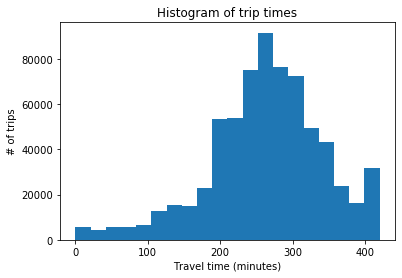

In [184]:
person_data.hist(column='num_steps', bins=20)
plt.xlabel('Travel time (minutes)')
plt.ylabel('# of trips')
plt.title('Histogram of trip times')
plt.grid(False)




In [185]:
max(person_data['num_steps'])

420.0

In [186]:
np.mean(person_data['num_steps'])

263.38980626860325

In [187]:
np.median(person_data['num_steps'])

266.56666666666666

In [188]:
np.std(person_data['num_steps'])

79.68788434723618

# Histogram of distance traveled

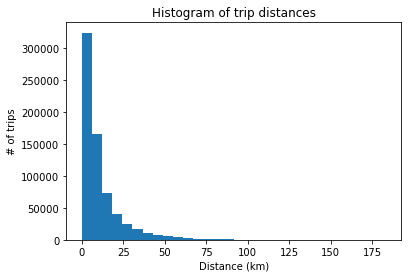

In [189]:
person_data['distance'] = person_data['distance'] / 1000
person_data.hist(column='distance', bins=30)
plt.xlabel('Distance (km)')
plt.ylabel('# of trips')
plt.title('Histogram of trip distances')
plt.grid(False)

In [141]:
max(person_data['distance'])

183.369

In [142]:
np.mean(person_data['distance'])

10.347197747564818

# Histogram of gas consumed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e8894a8>]],
      dtype=object)

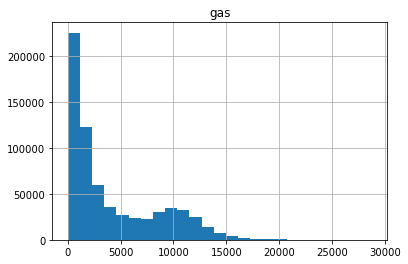

In [143]:
person_data.hist(column='gas', bins=25)

# Histogram of CO^2 emitted

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x173a622b0>]],
      dtype=object)

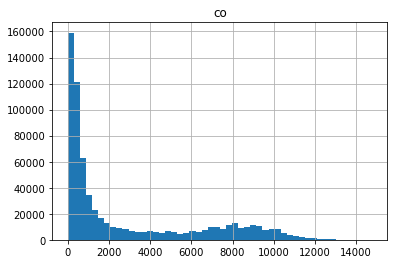

In [144]:
person_data.hist(column='co', bins=50)

# Histogram of departure times

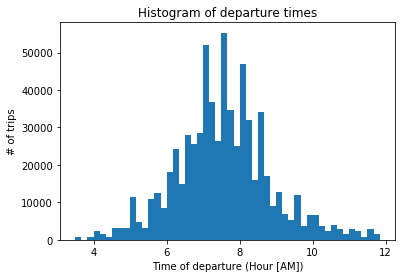

In [145]:
person_data['time_departure'] = person_data['time_departure'] / 3600
person_data.hist(column='time_departure', bins=50)
plt.xlabel('Time of departure (Hour [AM])')
plt.ylabel('# of trips')
plt.title('Histogram of departure times')
plt.grid(False)

# Histogram of average velocity

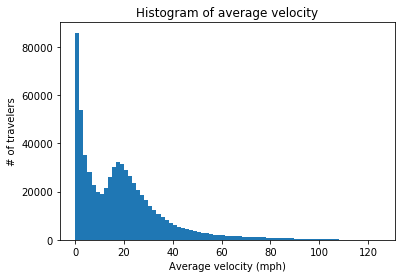

In [147]:
person_data['avg_v_real_mph'] = person_data['avg_v(mph)'] * 3600 / 1609.34
person_data.hist(column='avg_v(mph)', bins=75)
plt.xlabel('Average velocity (mph)')
plt.ylabel('# of travelers')
plt.title('Histogram of average velocity')
plt.grid(False)

In [148]:
avg_vel = person_data['avg_v(mph)']

In [149]:
max(avg_vel)

124.74700000000001

In [150]:
min(avg_vel)

0.0

In [151]:
np.mean(avg_vel)

18.914983165090213

In [152]:
person_data[person_data['p']==13]['avg_v(mph)']

13    20.3077
Name: avg_v(mph), dtype: float64

# Plot histogram of number of time steps for all travelers

In [266]:
output_list = []

num_steps_list = []
for run in range(100):
    try:
    #with open('new_point_5/test_point_5_sec_output_run_{}.csv'.format(run), 'r') as reader:
        with open('newest_point_5/test_point_5_sec_num_steps_time_range_7_hr_run_{}.csv'.format(run), 'r') as reader:
    # Read & print the entire file
            print("RUN {}\n".format(run))
            try:
                #num_steps = int(reader.read().split("num steps")[1].split("Avg")[0]) #from the actual printed output
                num_steps = int(reader.read()) #from num_steps.txt
                print(num_steps)
                num_steps_list += [num_steps,]
            except:
                print("Couldn't parse run {}".format(run))
    except:
        print("Couldn't open file of run {}".format(run))

RUN 0

2411514921
RUN 1

2479333617
RUN 2

2426797164
RUN 3

2386481853
RUN 4

2466999725
RUN 5

2477884827
RUN 6

2474595473
RUN 7

2474031319
RUN 8

2487242932
RUN 9

2469348107
RUN 10

2436311918
RUN 11

2461503284
RUN 12

2488911697
RUN 13

2438698585
RUN 14

2443111526
RUN 15

2465558619
RUN 16

2448208756
RUN 17

2448111524
RUN 18

2481956186
RUN 19

2433174902
RUN 20

2428922674
RUN 21

2443197512
RUN 22

2413586921
RUN 23

2449567676
RUN 24

2489336444
RUN 25

2480755458
RUN 26

2403042733
RUN 27

2466829559
RUN 28

2397758295
RUN 29

2420030289
RUN 30

2444710530
RUN 31

2471698152
RUN 32

2428815414
RUN 33

2459744469
RUN 34

2437597055
RUN 35

2431559054
RUN 36

2455328087
RUN 37

2434280103
RUN 38

2380099846
RUN 39

2522119072
RUN 40

2465426998
RUN 41

2403271913
RUN 42

2441867651
RUN 43

2460274883
RUN 44

2431707600
RUN 45

2456233355
RUN 46

2468056555
RUN 47

2486934252
RUN 48

2440668402
RUN 49

2453960652
RUN 50

2458052461
RUN 51

2444377693
RUN 52

2427671423
RUN

In [276]:
#num_steps_array = np.array(num_steps_list) / 3600
np.mean(num_steps_array)

680239.2307361113

In [268]:
(max(num_steps_array) - min(num_steps_array)) / np.mean(num_steps_array)

0.057993986846818585

In [269]:
(max(num_steps_array) - min(num_steps_array))

39449.78500000003

In [277]:
np.std(num_steps_array)

7955.093109020472

Text(0, 0.5, 'Number of runs')

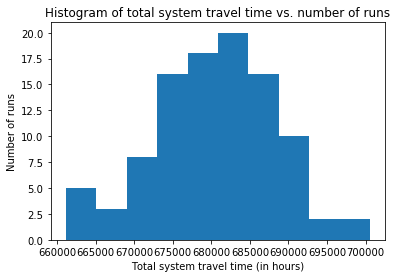

In [270]:
plt.hist(num_steps_array, bins=10)
plt.title("Histogram of total system travel time vs. number of runs")
plt.xlabel("Total system travel time (in hours)")
plt.ylabel("Number of runs")

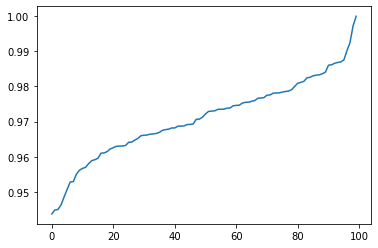

In [271]:
sorted_num_steps = np.sort(num_steps_array)
normalized_num_steps = sorted_num_steps / max(sorted_num_steps)
plt.plot(normalized_num_steps)

# Look at all paths list and make sure the count of -1s is 792910

In [13]:
all_paths = pd.read_csv('all_paths_incl_zeros.txt', sep=" ", header=None)

In [14]:
all_paths.head()

,0
0,-1
1,161950
2,403870
3,161959
4,161961


In [15]:
all_paths[0].value_counts()

-1         792910
 160384      6810
 19539       6689
 403917      6685
 163179      6622
            ...  
 275200         1
 123324         1
 209889         1
 334714         1
 323798         1
Name: 0, Length: 188301, dtype: int64

# Compare num_steps across timesteps

In [2]:
time_steps = ['point_1', 'point_2', 'point_3', 'point_4', 'point_5', 'point_6', 'point_7', 'point_8', 'point_9', 1, 2, 10, 20] #in seconds
num_steps_list = []
for step in time_steps:
    #with open('new_point_5/test_point_5_sec_output_run_{}.csv'.format(run), 'r') as reader:
    with open('num_steps_per_timestep/test_{}_sec_num_steps_run_0.csv'.format(step), 'r') as reader:
    # Read & print the entire file
        try:
            #num_steps = int(reader.read().split("num steps")[1].split("Avg")[0]) #from the actual printed output
            num_steps = int(reader.read()) #from num_steps.txt
            print(num_steps)
            num_steps_list += [num_steps,]
        except:
            print("Couldn't parse run {}".format(run))



479820441
169747437
112588051
122596219
20238877
11200718
48409741
42219077
7733363
4279345627
4259760115
865597755
409052696


[133283.45583333334, 47152.065833333334, 31274.45861111111, 34054.505277777775, 5621.910277777778, 3111.3105555555558, 13447.150277777779, 11727.521388888888, 2148.156388888889, 1188707.118611111, 1183266.6986111111, 240443.82083333333, 113625.74888888889]


Text(0, 0.5, 'Total system travel time (hours)')

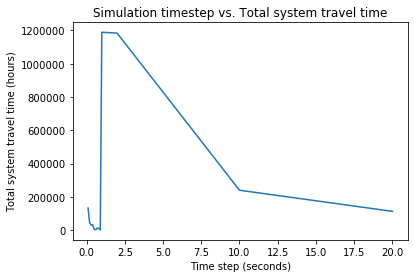

In [3]:
num_steps_list = [x / 3600 for x in num_steps_list] #in minutes
num_steps_list = num_steps_list
print(num_steps_list)

time_steps = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 10, 20] #in seconds
plt.plot(time_steps, num_steps_list, label='Simulation')
plt.title('Simulation timestep vs. Total system travel time')
plt.xlabel("Time step (seconds)")
plt.ylabel("Total system travel time (hours)")

# Compare to CHTS trips data

In [196]:
households = pd.read_csv("caltrans_full_survey/survey_households.csv", low_memory=False)
households_ba = households[households.home_county_id.isin([1, 13, 41, 55, 75, 81, 85, 95, 97])]


In [278]:
households_ba.head()

,sampno,assn,recruite_date,dow,home_block_id,home_tract_id,home_county_id,home_state_id,home_primarycity,home_city,...,noveh2,noveh3,noveh4,noveh5,noveh6,noveh7,noveh8,hhwgt,exphhwgt,geom
17,2985298,12818.0,2012-11-28,2.0,REDACTED,6.085510e+09,85.0,6.0,MOUNTAIN VIEW,MOUNTAIN VIEW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.942942,276.301960,REDACTED
18,2985550,12855.0,2012-12-31,4.0,REDACTED,6.085510e+09,85.0,6.0,MOUNTAIN VIEW,MOUNTAIN VIEW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.942942,276.301960,REDACTED
19,2985904,12779.0,2012-10-18,5.0,REDACTED,6.085509e+09,85.0,6.0,SUNNYVALE,SUNNYVALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.360746,398.727274,REDACTED
20,2986280,12784.0,2012-10-20,3.0,REDACTED,6.085509e+09,85.0,6.0,SUNNYVALE,SUNNYVALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.151281,337.349614,REDACTED
21,2986316,12779.0,2012-11-04,5.0,REDACTED,6.085509e+09,85.0,6.0,SUNNYVALE,SUNNYVALE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.852538,249.811708,REDACTED


In [197]:
households_ba.home_city.value_counts()[:15]

SAN FRANCISCO    1076
SAN JOSE          939
OAKLAND           459
SANTA ROSA        321
BERKELEY          251
NAPA              228
PALO ALTO         218
SUNNYVALE         200
SAN MATEO         197
FREMONT           177
WALNUT CREEK      173
REDWOOD CITY      170
FAIRFIELD         159
CONCORD           158
SAN RAFAEL        158
Name: home_city, dtype: int64

In [198]:
places = pd.read_csv("caltrans_full_survey/survey_place.csv", low_memory=False)

In [199]:
len(places)

460524

In [200]:
#filter to Bay Area
places_ba = places[places.sampno.isin(households_ba.sampno)]

len(places_ba)

117345

In [279]:
places_ba.head()

,sampno,perno,plano,vehno,tripno,place_name,travel_date,arr_time,dep_time,mode,...,lon,lat,non_hh_members,route,per1,per2,per3,per4,per5,geom
0,1031985,1,1,NaN,NaN,REDACTED,2012-05-01,2019-09-13 03:00:00,2019-09-13 08:00:00,NaN,...,REDACTED,REDACTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
1,1031985,1,2,97.0,1.0,REDACTED,2012-05-01,2019-09-13 09:00:00,2019-09-13 12:00:00,6.0,...,REDACTED,REDACTED,1.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
2,1031985,1,3,97.0,2.0,REDACTED,2012-05-01,2019-09-13 13:00:00,2019-09-13 02:00:00,6.0,...,REDACTED,REDACTED,1.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
3,1031985,2,1,NaN,NaN,REDACTED,2012-05-01,2019-09-13 03:00:00,2019-09-13 09:00:00,NaN,...,REDACTED,REDACTED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
4,1031985,2,2,1.0,1.0,REDACTED,2012-05-01,2019-09-13 09:00:00,2019-09-13 10:00:00,5.0,...,REDACTED,REDACTED,0.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED


In [280]:
for x in places_ba.columns:
    print(x)

sampno
perno
plano
vehno
tripno
place_name
travel_date
arr_time
dep_time
mode
trip_distance_miles
air_trip_distance_miles
tripdistanceflag
prev_trip_duration_min
act_dur
act_cnt
block_id
tract_id
county_id
state_id
place_primarycity
city
zipcode
state
parked_loc_type
parked_other_loc_type
parked_address
parked_minutes
parked_payed
parked_amount_payed
parked_unit
parked_pay_type
parked_other_pay_type
parked_paymen_ne
got_out_vehicle
transit_system
transit_system_other
perwgt
expperwgt
tcf
tcfperwgt
exptcfperwgt
tottr
hhmem
lon
lat
non_hh_members
route
per1
per2
per3
per4
per5
geom


In [201]:
len(places_ba.groupby(['sampno', 'perno', 'plano']))

117345

In [202]:
places_ba.tripno.count()

93406

In [203]:
places_ba.city.value_counts().head(15)

SAN FRANCISCO    15680
SAN JOSE         11414
OAKLAND           5455
SANTA ROSA        3441
BERKELEY          3185
PALO ALTO         2664
SUNNYVALE         2440
SAN MATEO         2190
NAPA              2160
FREMONT           2126
REDWOOD CITY      2067
MOUNTAIN VIEW     1948
WALNUT CREEK      1896
SANTA CLARA       1816
CONCORD           1800
Name: city, dtype: int64

In [445]:
places_ba.

0         REDACTED
1         REDACTED
2         REDACTED
3         REDACTED
4         REDACTED
            ...   
460291    REDACTED
460292    REDACTED
460293    REDACTED
460294    REDACTED
460295    REDACTED
Name: geom, Length: 117345, dtype: object

In [212]:
places_ba['arr_time'] = pd.to_datetime(places_ba['arr_time'])
places_ba['dep_time'] = pd.to_datetime(places_ba['dep_time'])

/anaconda3/envs/traffic_microsim/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/envs/traffic_microsim/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [281]:
#how many different tracts are visited?
places_ba.tract_id.unique().shape[0]

2296

In [282]:
#how many different people?
len(places_ba.groupby(['sampno','perno']))

23939

In [283]:
# Is the mapping between census tracts and city names consistent? -- No

print(places.tract_id.drop_duplicates().shape[0])
print(places[['tract_id', 'city']].drop_duplicates().shape[0])

6912
14388


In [284]:
# How to deal with this? I think `tract_id` is an integer representation
# of the 4-digit tract ID within the couty plus the 2 digit suffix. 

# So the full unique identifier is `state_id` + `county_id` (3 digits) + `tract_id` (6 digits)

places['_full_tract_id'] = places.state_id * 1e9 + places.county_id * 1e6 + places.tract_id

# Presumably the all-9 entries reflect missing data, but documentation doesn't specify

places.ix[(places.tract_id == 999999) |
          (places.county_id == 999) |
          (places.state_id == 99), '_full_tract_id'] = np.nan

/anaconda3/envs/traffic_microsim/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [285]:
print(places._full_tract_id.drop_duplicates().shape[0])
print(places[['_full_tract_id', 'city']].drop_duplicates().shape[0])

9098
14194


In [286]:
# Map each tract to its most common corresponding city

tracts = places[['_full_tract_id', 'city']].groupby('_full_tract_id').\
        agg(lambda x:x.value_counts().index[0])
    
print(tracts.head())

                      city
_full_tract_id            
1.015001e+09      ANNISTON
1.101002e+09    MONTGOMERY
1.161400e+09       SEVILLA
2.020001e+09     ANCHORAGE
2.020001e+09     ANCHORAGE


In [287]:
places_ba.groupby(['sampno', 'perno']).plano.max().head(10)

sampno   perno
1031985  1         3
         2         3
1033944  1        16
1035274  1         8
         2         6
1037952  1         3
         2         1
1039620  1         5
         2         5
1041076  1         4
Name: plano, dtype: int64

In [288]:
# Do any respondents have multiple trip sequences? -- No!

plano_counts = places_ba.groupby(['sampno', 'perno']).plano.max()
tripno_counts = places_ba.groupby(['sampno', 'perno']).tripno.max()

(plano_counts - tripno_counts).describe()

count    19512.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [289]:
# What does a sequence of places look like?

varlist = ['travel_date', 'arr_time', 'dep_time', 'tract_id', 'city', 'mode', 
           'trip_distance_miles', 'prev_trip_duration_min', 'act_dur']

places_ba.loc[(places_ba.sampno == 1035274) & (places_ba.perno == 1), varlist]

,travel_date,arr_time,dep_time,tract_id,city,mode,trip_distance_miles,prev_trip_duration_min,act_dur
152,2012-07-17,2019-09-13 03:00:00,2019-09-13 10:00:00,509000.0,SUNNYVALE,NaN,NaN,NaN,425.0
153,2012-07-17,2019-09-13 10:00:00,2019-09-13 10:00:00,509000.0,SUNNYVALE,5.0,0.572830,10.0,30.0
154,2012-07-17,2019-09-13 11:00:00,2019-09-13 11:00:00,508504.0,SUNNYVALE,5.0,2.311855,15.0,1.0
155,2012-07-17,2019-09-13 11:00:00,2019-09-13 11:00:00,508504.0,SUNNYVALE,1.0,0.226491,5.0,9.0
156,2012-07-17,2019-09-13 11:00:00,2019-09-13 13:00:00,508504.0,SUNNYVALE,1.0,0.226491,5.0,105.0
157,2012-07-17,2019-09-13 13:00:00,2019-09-13 14:00:00,509000.0,SUNNYVALE,5.0,2.345337,10.0,60.0
158,2012-07-17,2019-09-13 14:00:00,2019-09-13 15:00:00,500100.0,SAN JOSE,5.0,8.289089,20.0,25.0
159,2012-07-17,2019-09-13 15:00:00,2019-09-13 02:00:00,509000.0,SUNNYVALE,5.0,8.587044,20.0,699.0


In [292]:
places_ba_cars = places_ba[(places_ba['mode'] >= 5) & (places_ba['mode'] <= 10)]

In [293]:
places_ba_cars.head()

,sampno,perno,plano,vehno,tripno,place_name,travel_date,arr_time,dep_time,mode,...,lon,lat,non_hh_members,route,per1,per2,per3,per4,per5,geom
1,1031985,1,2,97.0,1.0,REDACTED,2012-05-01,2019-09-13 09:00:00,2019-09-13 12:00:00,6.0,...,REDACTED,REDACTED,1.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
2,1031985,1,3,97.0,2.0,REDACTED,2012-05-01,2019-09-13 13:00:00,2019-09-13 02:00:00,6.0,...,REDACTED,REDACTED,1.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
4,1031985,2,2,1.0,1.0,REDACTED,2012-05-01,2019-09-13 09:00:00,2019-09-13 10:00:00,5.0,...,REDACTED,REDACTED,0.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
5,1031985,2,3,1.0,2.0,REDACTED,2012-05-01,2019-09-13 10:00:00,2019-09-13 02:00:00,5.0,...,REDACTED,REDACTED,0.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED
127,1033944,1,10,97.0,9.0,REDACTED,2012-05-01,2019-09-13 18:00:00,2019-09-13 20:00:00,6.0,...,REDACTED,REDACTED,1.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED


In [294]:
places_ba_cars.shape[0]

69986

In [297]:
places_ba_commute = places_ba_cars[(places_ba_cars['dep_time'] > '2019-09-13 05:00:00')\
                              & (places_ba_cars['dep_time'] < '2019-09-13 12:00:00')\
                              & (places_ba_cars['arr_time'] < '2019-09-13 12:00:00')\
                              & (places_ba_cars['arr_time'] > '2019-09-13 05:00:00')]


In [298]:
places_ba_commute.shape[0]

11515

In [299]:
places_ba_commute['trip_distance_km'] = places_ba_commute['trip_distance_miles'] * 1.60934

/anaconda3/envs/traffic_microsim/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


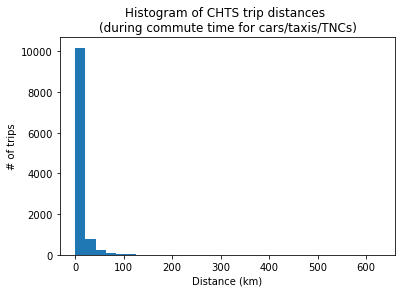

In [350]:
places_ba_commute.hist(column='trip_distance_km', bins=30)
plt.title("Histogram of CHTS trip distances \n(during commute time for cars/taxis/TNCs)")
plt.xlabel("Distance (km)")
plt.ylabel("# of trips")
plt.grid(False)

In [361]:
max(places_ba_commute['trip_distance_km'])

628.0137701309

In [362]:
np.mean(places_ba_commute['trip_distance_km'])

9.981059904385257

In [306]:
#places_ba_commute['trip_time'] = places_ba_commute['arr_time'] - places_ba_commute['dep_time']
#places_ba_commute['trip_time']= places_ba_commute['trip_time']/np.timedelta64(1,'h')



In [307]:
#places_ba_commute['trip_time'].apply(lambda x: x + 24 if x < 0)
#places_ba_commute['trip_time_pos'] = places_ba_commute['trip_time']
#places_ba_commute.loc[places_ba_commute.trip_time < 0, 'trip_time_pos'] = places_ba_commute.trip_time + 24

In [302]:
places_ba_commute.tail()

,sampno,perno,plano,vehno,tripno,place_name,travel_date,arr_time,dep_time,mode,...,non_hh_members,route,per1,per2,per3,per4,per5,geom,trip_distance_km,trip_time
460272,7211560,1,2,1.0,1.0,REDACTED,2013-01-30,2019-09-13 08:00:00,2019-09-13 08:00:00,5.0,...,0.0,NaN,4.0,NaN,NaN,NaN,NaN,REDACTED,20.887189,0.0
460273,7211560,1,3,1.0,2.0,REDACTED,2013-01-30,2019-09-13 09:00:00,2019-09-13 11:00:00,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED,22.133609,-2.0
460282,7211560,2,3,97.0,2.0,REDACTED,2013-01-30,2019-09-13 08:00:00,2019-09-13 09:00:00,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED,7.745461,-1.0
460283,7211560,2,4,97.0,3.0,REDACTED,2013-01-30,2019-09-13 09:00:00,2019-09-13 11:00:00,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED,0.263335,-2.0
460284,7211560,2,5,97.0,4.0,REDACTED,2013-01-30,2019-09-13 11:00:00,2019-09-13 11:00:00,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,REDACTED,11.754909,0.0


In [303]:
#places_ba_commute['trip_time'].apply(lambda x: x + 24 if x < 0)
places_ba_commute['trip_time_pos'] = places_ba_commute['trip_time']
places_ba_commute.loc[places_ba_commute.trip_time < 0, 'trip_time_pos'] = places_ba_commute.trip_time + 24

/anaconda3/envs/traffic_microsim/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [309]:
places_ba_commute.shape[0]

11515

Text(0, 0.5, 'Number of trips')

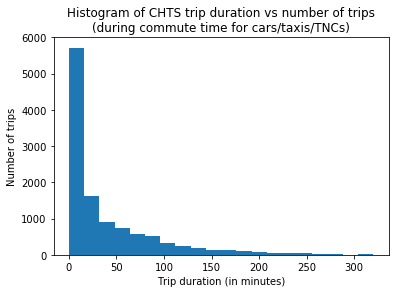

In [317]:
places_ba_commute.hist(column='act_dur', bins=20, range=[0,320])
plt.grid(False)
plt.title("Histogram of CHTS trip duration vs number of trips\n(during commute time for cars/taxis/TNCs)")
plt.xlabel("Trip duration (in minutes)")
plt.ylabel("Number of trips")

In [366]:
max(places_ba_commute['act_dur'])

328.0

In [367]:
np.mean(places_ba_commute['act_dur'])

39.66183239253148

In [443]:
np.median(places_ba_commute['act_dur'])

16.0

In [361]:
max(places_ba_commute['trip_distance_km'])

628.0137701309

In [410]:
np.std(places_ba_commute['trip_distance_km'])

22.14903427665679

# UNUSED STUFF

# Plot the above centrality on the street graph

In [42]:
input_graphml_file = 'full_network_simplified.graphml'

G = ox.load_graphml(input_graphml_file)

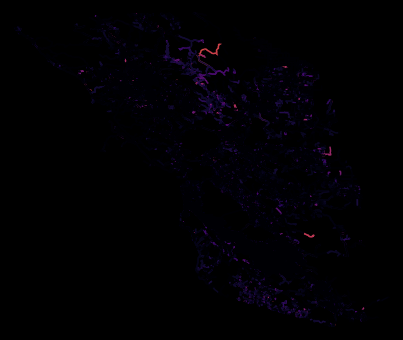

In [46]:
# list of edge values for the orginal graph
#ev = [edge_totals[edge] for edge in G.edges()]
ev = list(edge_totals['flow'])

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

#ev

# Plot figure ground around particular area

In [150]:
size = 240
dpi = 40
point = (37.75, -122.5)
fig, ax = ox.plot_figure_ground(point=point, network_type='all', default_width=3.3, dpi=dpi)

# Plot the shapefile of the Bay Area

In [34]:
bay_area_streets = gpd.read_file("urbanized_areas2000.shp")

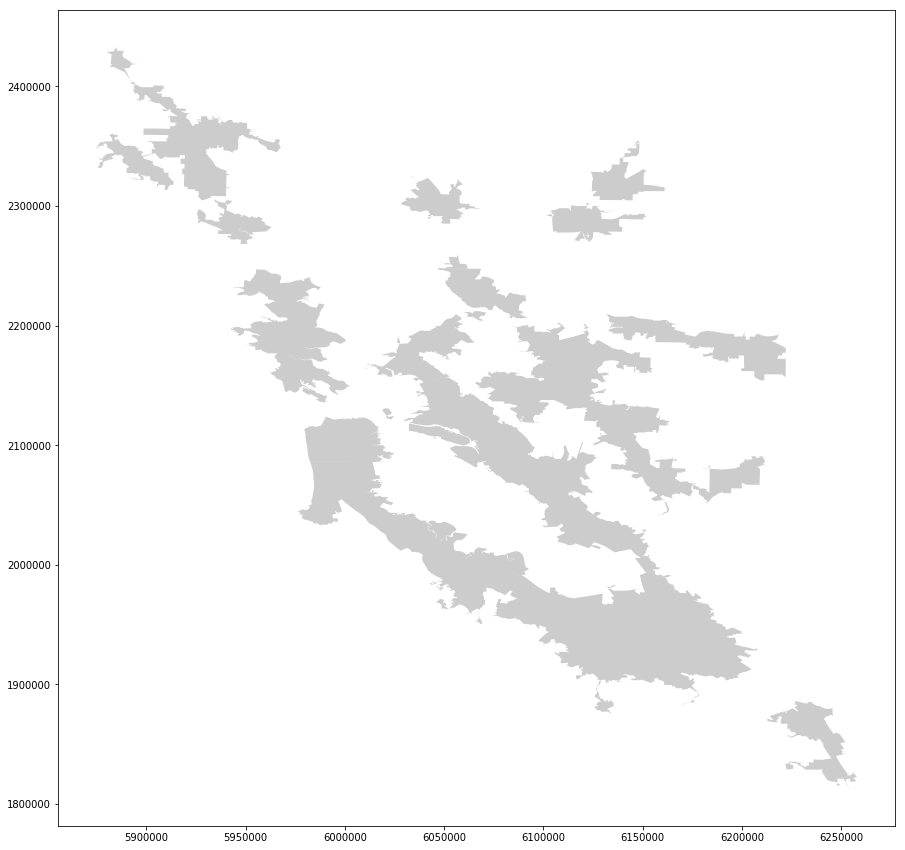

In [49]:
fig, ax = plt.subplots(figsize=[15,15])
bay_area_streets.plot(ax = ax, alpha = .4, color = 'grey', figsize=[15,15])

# Get the min and max lat and long so we can plot the bounding box

In [12]:
nodes = pd.read_csv("nodes.csv")

In [13]:
nodes.head()

,osmid,x,y,ref,highway
0,309330024,-122.354382,37.587447,NaN,NaN
1,247385811,-122.014259,37.337711,NaN,traffic_signals
2,247385814,-122.015335,37.335105,NaN,NaN
3,4353687911,-122.445425,37.731519,NaN,NaN
4,4353687912,-122.445424,37.731608,NaN,NaN


In [14]:
min_x = min(nodes['x'])
min_y = min(nodes['y'])

max_x = max(nodes['x'])
max_y = max(nodes['y'])

min_x, min_y, max_x, max_y

(-123.543742, 36.880457, -121.273774, 38.87769)

# Map the bounding box

In [15]:
G = ox.graph_from_bbox(max_y, min_y, max_x, min_x, network_type='drive')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

NameError: name 'ox' is not defined

# Map all nodes using geopandas

In [25]:
#plot lat-longs on map
def make_point(row):
    return Point(row.x, row.y)

# Go through every row, and make a point out of its lat and lon
points = nodes.apply(make_point, axis=1)

# Make a new GeoDataFrame
# using the data from our old df
# but also adding in the geometry we just made
nodes_map = gpd.GeoDataFrame(nodes, geometry=points)

# It doesn't come with a CRS because it's a CSV, so let's
# say "hey, let's use the standard shape of the earth etc"
nodes_map.crs = {'init': 'epsg:4326'}

In [24]:
#look at the first few
nodes_map.head()

,osmid,x,y,ref,highway,geometry
0,309330024,-122.354382,37.587447,NaN,NaN,POINT (-122.3543825 37.5874468)
1,247385811,-122.014259,37.337711,NaN,traffic_signals,POINT (-122.0142588 37.337711)
2,247385814,-122.015335,37.335105,NaN,NaN,POINT (-122.0153351 37.3351054)
3,4353687911,-122.445425,37.731519,NaN,NaN,POINT (-122.4454249 37.7315189)
4,4353687912,-122.445424,37.731608,NaN,NaN,POINT (-122.4454242 37.7316082)


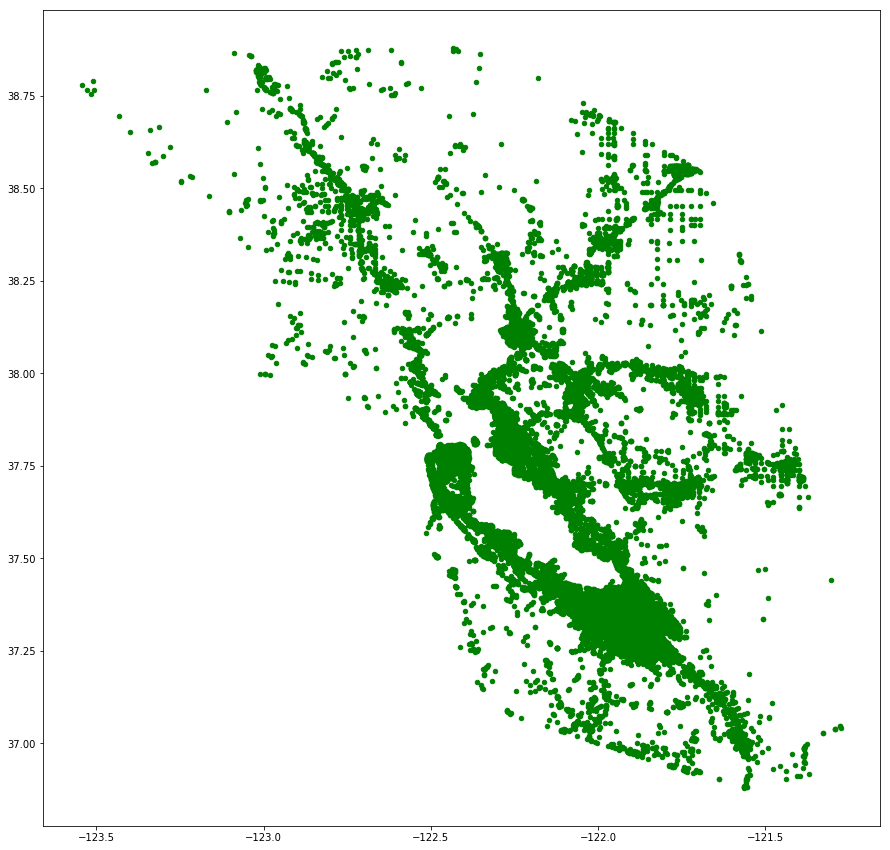

In [56]:
#plot nodes lat-long
fig, ax = plt.subplots(figsize=[15,15])
nodes_map.plot(ax=ax, markersize=20, color='green')
#bay_area_streets.plot(ax = ax, alpha = .4, color = 'grey')
#plt.legend(prop={'size': 15})
#ax.axis('on')